<a href="https://colab.research.google.com/github/pushkar-hue/Foresight/blob/main/lstm_for_household_electric_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/electric-power-consumption-data-set


In [ ]:
cd /kaggle/input/electric-power-consumption-data-set

/kaggle/input/electric-power-consumption-data-set


In [ ]:
ls

household_power_consumption.txt


In [ ]:
path +="/household_power_consumption.txt"

In [ ]:
path

'/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt'

Data shape after initial processing: (2049280, 7)
Data period: 2006-12-16 17:24:00 to 2010-11-26 21:02:00

Raw data split:
Train period: 2006-12-16 17:24:00 to 2009-11-14 15:11:00
Test period: 2009-11-14 15:12:00 to 2010-11-26 21:02:00
Train samples: 1523680, Test samples: 525600

After resampling to hourly:
Train shape: (25535, 7)
Test shape: (9055, 7)

Missing values in train after filling: 0
Missing values in test after filling: 0

Final feature columns: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']
Scaled train shape: (25535, 13)
Scaled test shape: (9055, 13)

Supervised dataset shapes:
Train reframed: (25511, 313)
Test reframed: (9031, 313)

Final shapes:
train_X: (20408, 24, 13), train_y: (20408,)
val_X: (5103, 24, 13), val_y: (5103,)
test_X: (9031, 24, 13), test_y: (9031,)

Using device: cpu

PyTorch Model

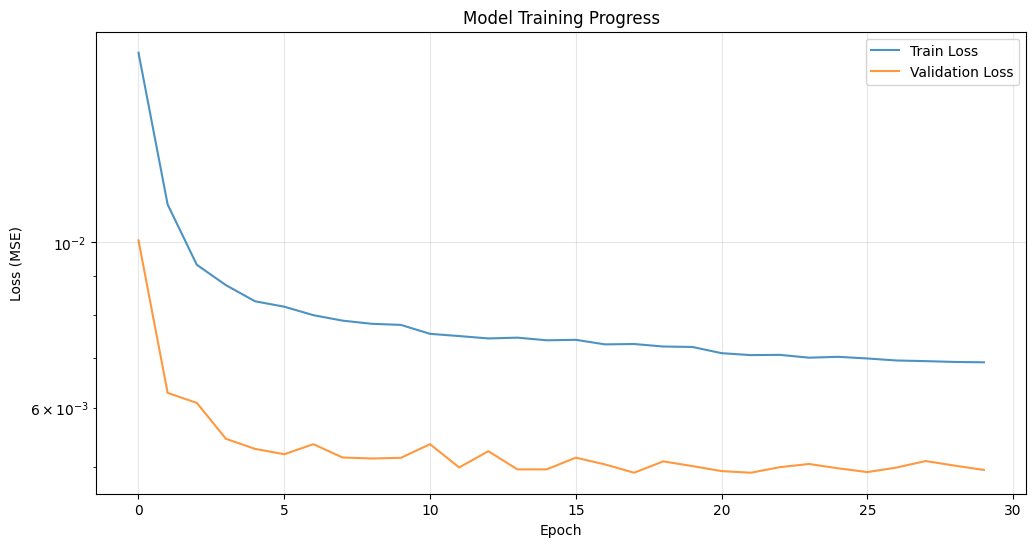


TEST SET EVALUATION METRICS
RMSE: 0.490 kW
MAE: 0.335 kW
MAPE: 36.46%
MAPE (v2): 36.46%
Mean actual value: 1.098 kW
Std actual value: 0.798 kW


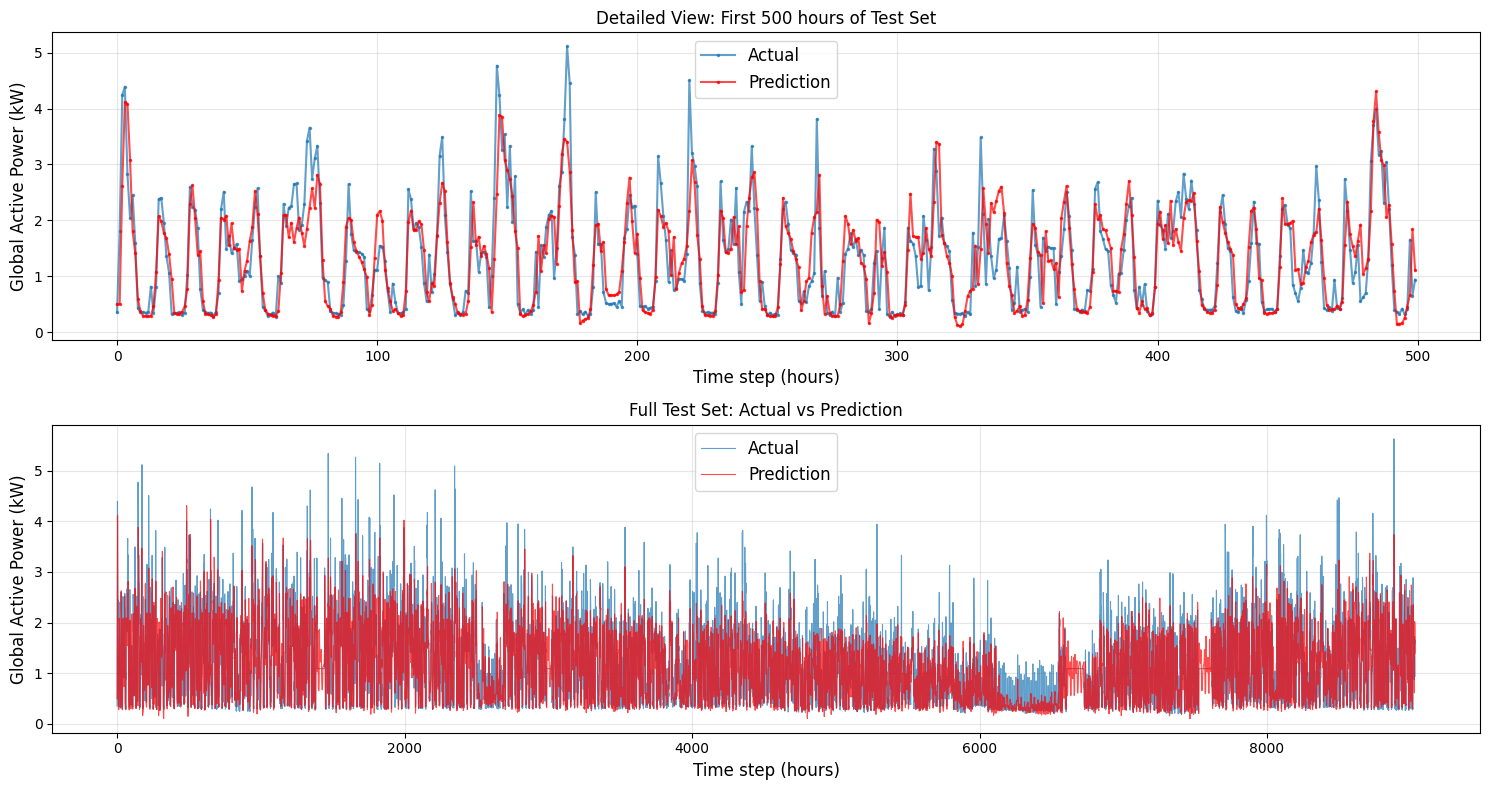

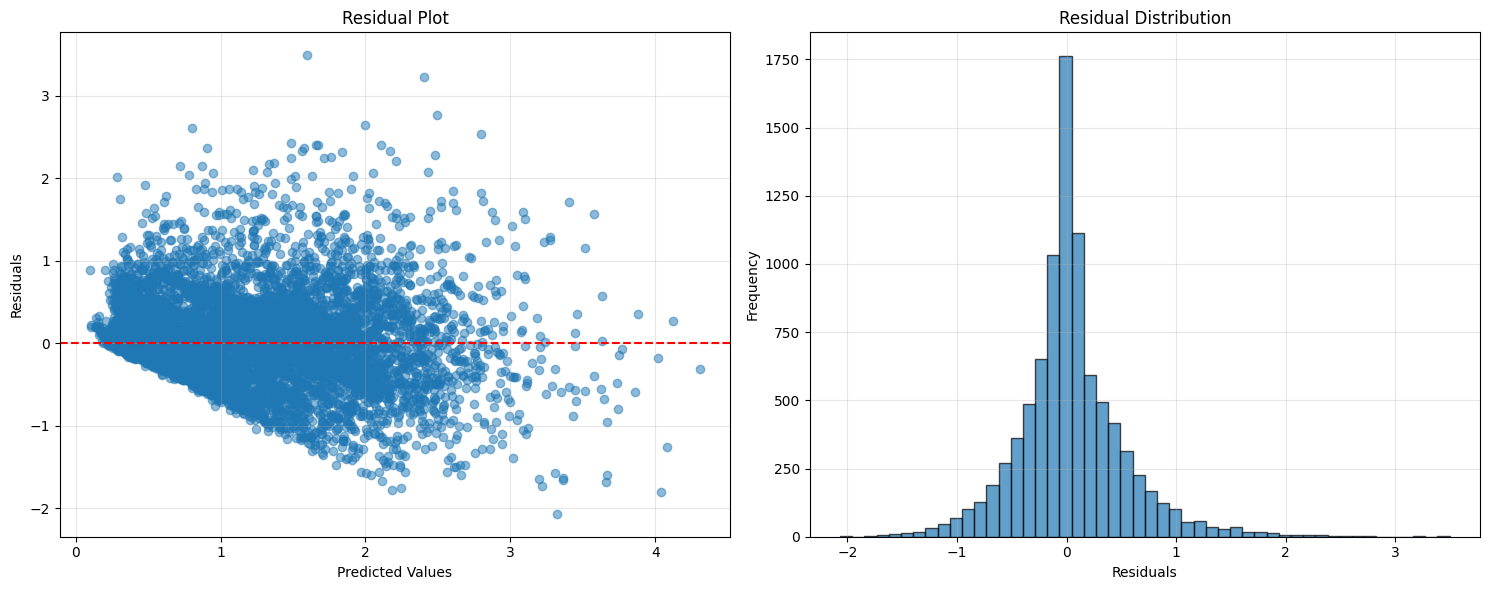


RESIDUAL ANALYSIS:
Mean residual: 0.0397
Std residual: 0.4883
Min residual: -2.0655
Max residual: 3.4938
Correlation coefficient: 0.7933

MODEL SUMMARY:
- Lookback window: 24 hours
- Number of features: 13
- Training samples: 20,408
- Validation samples: 5,103
- Test samples: 9,031
- Best validation loss: 0.00491
- Final test RMSE: 0.490 kW

✅ DATA LEAKAGE PREVENTION MEASURES IMPLEMENTED:
1. ✅ Train/test split performed on raw data BEFORE resampling
2. ✅ Independent resampling of train and test sets
3. ✅ Scaler fitted only on training data
4. ✅ Missing value fill statistics computed only from training data
5. ✅ No future information used in feature engineering
6. ✅ Temporal order preserved throughout pipeline


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


# Load the dataset
path = '/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt' # Use the correct path from previous cells
df = pd.read_csv(path, sep=';', low_memory=False, na_values=['nan', '?'])

# Validate required columns exist
required_cols = ['Date', 'Time', 'Global_active_power']
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"Missing one or more required columns: {required_cols}")

# Date parsing
df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df = df.set_index('dt')
df = df.drop(['Date', 'Time'], axis=1)

# Ensure numeric types
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows with invalid timestamps (NaT in index)
df = df.dropna(subset=[col for col in df.columns if col != 'dt']) # Drop rows with NaNs in any column except the index
df = df[~df.index.isnull()] # Drop rows where the index (dt) is NaT

print("Data shape after initial processing:", df.shape)
print(f"Data period: {df.index[0]} to {df.index[-1]}")


# Split on the original minute-level data to prevent any temporal leakage
# Keep the last year for testing
test_period_hours = 365 * 24
test_period_minutes = test_period_hours * 60

if len(df) < test_period_minutes + 1000:  # Ensure enough training data
    raise ValueError("Insufficient data for train/test split")

n_train = len(df) - test_period_minutes
train_df_raw = df.iloc[:n_train].copy()
test_df_raw = df.iloc[n_train:].copy()

print(f"\nRaw data split:")
print(f"Train period: {train_df_raw.index[0]} to {train_df_raw.index[-1]}")
print(f"Test period: {test_df_raw.index[0]} to {test_df_raw.index[-1]}")
print(f"Train samples: {len(train_df_raw)}, Test samples: {len(test_df_raw)}")


# Resample each set independently to hourly frequency
train_df = train_df_raw.resample('h').mean()
test_df = test_df_raw.resample('h').mean()

print(f"\nAfter resampling to hourly:")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


# Calculate filling values (e.g., mean) ONLY from the training set
fill_values = train_df.mean()

# Apply filling to both train and test sets
train_df.fillna(fill_values, inplace=True)
test_df.fillna(fill_values, inplace=True)

print(f"\nMissing values in train after filling: {train_df.isnull().sum().sum()}")
print(f"Missing values in test after filling: {test_df.isnull().sum().sum()}")


def add_time_features(data):
    """Add cyclical time features without data leakage"""
    data_copy = data.copy()
    data_copy['hour'] = data_copy.index.hour
    data_copy['day_of_week'] = data_copy.index.dayofweek
    data_copy['month'] = data_copy.index.month

    # Cyclical encoding for time features
    data_copy['hour_sin'] = np.sin(2 * np.pi * data_copy['hour']/24.0)
    data_copy['hour_cos'] = np.cos(2 * np.pi * data_copy['hour']/24.0)
    data_copy['day_of_week_sin'] = np.sin(2 * np.pi * data_copy['day_of_week']/7.0)
    data_copy['day_of_week_cos'] = np.cos(2 * np.pi * data_copy['day_of_week']/7.0)
    data_copy['month_sin'] = np.sin(2 * np.pi * data_copy['month']/12.0)
    data_copy['month_cos'] = np.cos(2 * np.pi * data_copy['month']/12.0)

    # Drop the original time features
    data_copy = data_copy.drop(['hour', 'day_of_week', 'month'], axis=1)
    return data_copy

train_df = add_time_features(train_df)
test_df = add_time_features(test_df)

target_col = 'Global_active_power'
# Ensure target column is first for easier processing later
cols = [target_col] + [col for col in train_df.columns if col != target_col]
train_df = train_df[cols]
test_df = test_df[cols]

print(f"\nFinal feature columns: {list(train_df.columns)}")


scaler = MinMaxScaler(feature_range=(0, 1))
# Fit AND transform on the training set
scaled_train = scaler.fit_transform(train_df)
# ONLY transform on the test set
scaled_test = scaler.transform(test_df)

print(f"Scaled train shape: {scaled_train.shape}")
print(f"Scaled test shape: {scaled_test.shape}")


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


n_steps = 24  # Look back 24 hours to predict next hour
n_features = train_df.shape[1]

# Reframe training data
train_reframed = series_to_supervised(scaled_train, n_steps, 1)
# Keep only the target variable ('var1(t)') at the output timestep
# Remove other features at time t since we only want to predict Global_active_power
cols_to_drop = [(n_steps * n_features) + i for i in range(1, n_features)]
train_reframed.drop(train_reframed.columns[cols_to_drop], axis=1, inplace=True)

# Reframe test data
test_reframed = series_to_supervised(scaled_test, n_steps, 1)
test_reframed.drop(test_reframed.columns[cols_to_drop], axis=1, inplace=True)

print(f"\nSupervised dataset shapes:")
print(f"Train reframed: {train_reframed.shape}")
print(f"Test reframed: {test_reframed.shape}")


train_values = train_reframed.values
train_size = int(len(train_values) * 0.8)
train, val = train_values[:train_size], train_values[train_size:]

# Split features and targets
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test_reframed.values[:, :-1], test_reframed.values[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
val_X = val_X.reshape((val_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

print(f"\nFinal shapes:")
print(f"train_X: {train_X.shape}, train_y: {train_y.shape}")
print(f"val_X: {val_X.shape}, val_y: {val_y.shape}")
print(f"test_X: {test_X.shape}, test_y: {test_y.shape}")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

train_X_tensor = torch.from_numpy(train_X).float().to(device)
train_y_tensor = torch.from_numpy(train_y).float().view(-1, 1).to(device)
val_X_tensor = torch.from_numpy(val_X).float().to(device)
val_y_tensor = torch.from_numpy(val_y).float().view(-1, 1).to(device)
test_X_tensor = torch.from_numpy(test_X).float().to(device)
test_y_tensor = torch.from_numpy(test_y).float().view(-1, 1).to(device)

# Create data loaders
batch_size = 70
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_X_tensor, val_y_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(test_X_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class BidirectionalLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, dropout):
        super(BidirectionalLSTMAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers,
                              batch_first=True, dropout=dropout, bidirectional=True)
        self.attention_weights = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Attention mechanism
        attn_scores = self.attention_weights(lstm_out).squeeze(-1)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context_vector = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)
        return out

# Model parameters
INPUT_DIM = n_features
HIDDEN_DIM = 128
N_LAYERS = 2
OUTPUT_DIM = 1
DROPOUT = 0.2

model = BidirectionalLSTMAttention(INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

print("\nPyTorch Model Architecture:")
print(model)
print(f"\nTotal trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


epochs = 30
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience = 15
patience_counter = 0
best_model_state = None

print(f"\nStarting training for {epochs} epochs...")
print("="*60)

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    validation_loss = running_val_loss / len(val_loader)
    val_losses.append(validation_loss)

    # Early stopping logic
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1

    # Learning rate scheduling
    scheduler.step()

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:2d}/{epochs} | Train Loss: {train_loss:.5f} | "
              f"Val Loss: {validation_loss:.5f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1} (patience exceeded)")
        break

# Load the best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with validation loss: {best_val_loss:.5f}")


plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.title('Model Training Progress')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visualization
plt.show()


model.eval()
with torch.no_grad():
    # Get predictions on the test set
    predictions_tensor = model(test_X_tensor)

# Move predictions to CPU and convert to numpy
yhat = predictions_tensor.cpu().numpy()


# To inverse transform predictions, we need to reconstruct the full feature vector
# The prediction is for the target variable (first column), so we need to
# concatenate it with the other features from the same time step

# For predictions: use the last timestep features from input sequence
inv_yhat = np.concatenate((yhat, test_X[:, -1, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]  # Extract only the target variable

# For actual values: same process
inv_y = np.concatenate((test_y.reshape(-1, 1), test_X[:, -1, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]  # Extract only the target variable


rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)

def safe_mape(y_true, y_pred):
    """Calculate MAPE while handling zero values safely"""
    mask = y_true != 0
    if np.sum(mask) > 0:
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        return np.nan

mape = safe_mape(inv_y, inv_yhat)

# Additional metrics
def mean_absolute_percentage_error_v2(y_true, y_pred):
    """Alternative MAPE calculation"""
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

mape_v2 = mean_absolute_percentage_error_v2(inv_y, inv_yhat)

print(f'\n{"="*50}')
print(f'TEST SET EVALUATION METRICS')
print(f'{"="*50}')
print(f'RMSE: {rmse:.3f} kW')
print(f'MAE: {mae:.3f} kW')
print(f'MAPE: {mape:.2f}%')
print(f'MAPE (v2): {mape_v2:.2f}%')
print(f'Mean actual value: {np.mean(inv_y):.3f} kW')
print(f'Std actual value: {np.std(inv_y):.3f} kW')
print(f'{"="*50}')


# Plot predictions vs actual
plt.figure(figsize=(15, 8))

# Plot first portion for detailed view
n_plot = min(500, len(inv_y))
plt.subplot(2, 1, 1)
plt.plot(inv_y[:n_plot], marker='.', label="Actual", alpha=0.7, markersize=3)
plt.plot(inv_yhat[:n_plot], 'r', marker='.', label="Prediction", alpha=0.7, markersize=3)
plt.ylabel('Global Active Power (kW)', size=12)
plt.xlabel('Time step (hours)', size=12)
plt.legend(fontsize=12)
plt.title(f'Detailed View: First {n_plot} hours of Test Set')
plt.grid(True, alpha=0.3)

# Plot entire test set
plt.subplot(2, 1, 2)
plt.plot(inv_y, label="Actual", alpha=0.7, linewidth=0.8)
plt.plot(inv_yhat, 'r', label="Prediction", alpha=0.7, linewidth=0.8)
plt.ylabel('Global Active Power (kW)', size=12)
plt.xlabel('Time step (hours)', size=12)
plt.legend(fontsize=12)
plt.title('Full Test Set: Actual vs Prediction')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


residuals = inv_y - inv_yhat

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(inv_yhat, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print(f'\nRESIDUAL ANALYSIS:')
print(f'Mean residual: {np.mean(residuals):.4f}')
print(f'Std residual: {np.std(residuals):.4f}')
print(f'Min residual: {np.min(residuals):.4f}')
print(f'Max residual: {np.max(residuals):.4f}')

# Correlation between actual and predicted
correlation = np.corrcoef(inv_y, inv_yhat)[0, 1]
print(f'Correlation coefficient: {correlation:.4f}')

print(f'\nMODEL SUMMARY:')
print(f'- Lookback window: {n_steps} hours')
print(f'- Number of features: {n_features}')
print(f'- Training samples: {len(train_X):,}')
print(f'- Validation samples: {len(val_X):,}')
print(f'- Test samples: {len(test_X):,}')
print(f'- Best validation loss: {best_val_loss:.5f}')
print(f'- Final test RMSE: {rmse:.3f} kW')

print(f'\n✅ DATA LEAKAGE PREVENTION MEASURES IMPLEMENTED:')
print(f'1. ✅ Train/test split performed on raw data BEFORE resampling')
print(f'2. ✅ Independent resampling of train and test sets')
print(f'3. ✅ Scaler fitted only on training data')
print(f'4. ✅ Missing value fill statistics computed only from training data')
print(f'5. ✅ No future information used in feature engineering')
print(f'6. ✅ Temporal order preserved throughout pipeline')

In [ ]:
torch.save(model.state_dict(), '/content/best_model.pth')